In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [15]:
train_val_data_dir = r'..\images\train'
img_height = 48
img_width = 48
batch_size = 32

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear' # opciono - metod, kod nas ne radimo resizing
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
test_data_dir = r'..\images\test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)



Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Za prebrojavanje slika po kategorijama:

In [16]:
def count_labels(dataset):
    counts = dict.fromkeys(dataset.class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[dataset.class_names[i]] += 1
    return counts

In [17]:
print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))

Train dataset: {'angry': 3229, 'disgust': 341, 'fear': 3294, 'happy': 5765, 'neutral': 3941, 'sad': 3935, 'surprise': 2552}
Validation dataset: {'angry': 764, 'disgust': 95, 'fear': 809, 'happy': 1399, 'neutral': 1041, 'sad': 1003, 'surprise': 653}
Test dataset: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


Prikaz prvih slika po kategorijama iz prvog batch-a: (random)

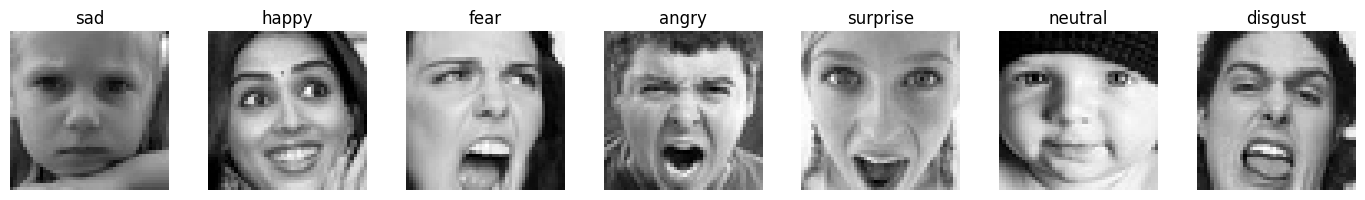

In [18]:

for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    class_names = train_ds.class_names

    first_of_class = {}  # prva slika po klasi

    for i in range(len(images)):
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]

        if class_name not in first_of_class:
            first_of_class[class_name] = images[i]

        if len(first_of_class) == len(class_names):
            break

    # broj klasa
    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona

    for ax, (class_name, image) in zip(axes, first_of_class.items()):
        ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Normalizacija:

In [19]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


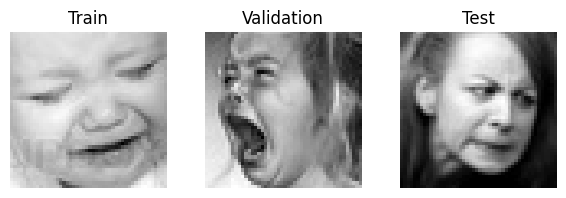

In [20]:
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikazi slike u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)


Augmentacija train seta:

In [ ]:
img_height = 48
img_width = 48

# augmentacione slojevi
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),  # ±10%
    tf.keras.layers.RandomContrast(0.1),  # ±10% kontrast
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # translacija do 10%
    tf.keras.layers.RandomZoom(0.1)  # blagi zoom
])

def augment_dataset(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


train_ds_aug = augment_dataset(train_ds)



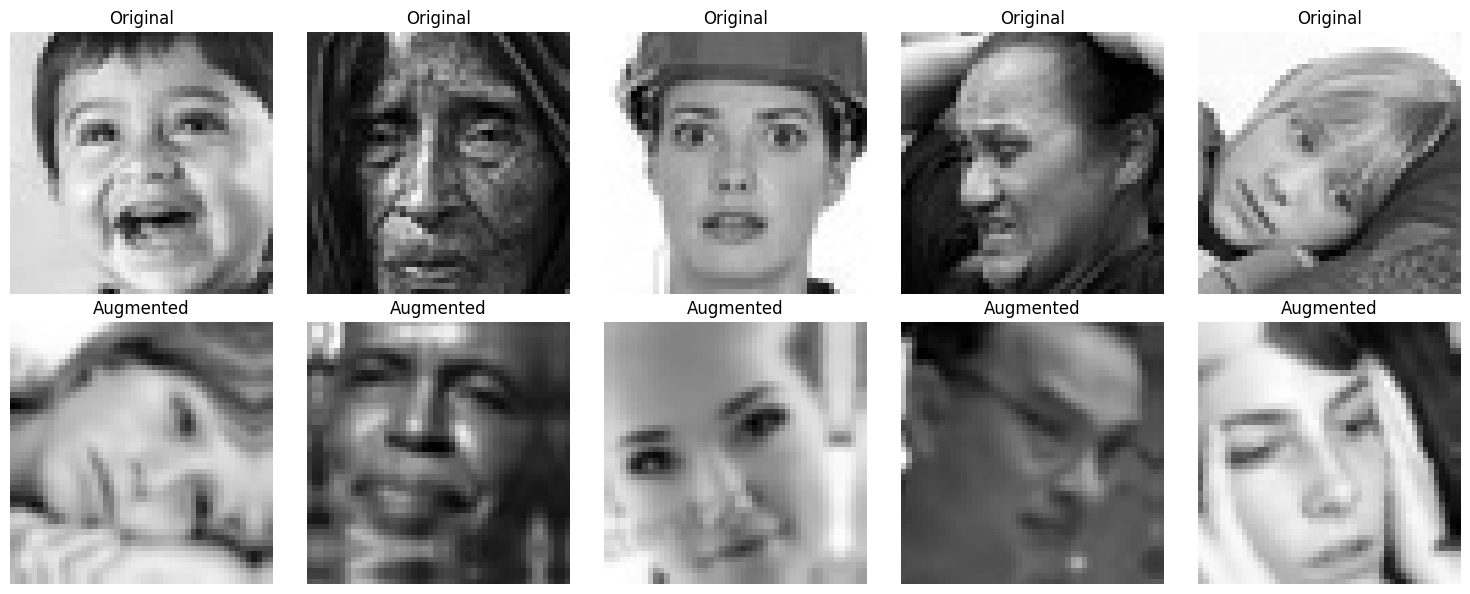

In [ ]:
# 1. batch iz augm DS-a
for images_aug, labels_aug in train_ds_aug.take(1):
    images_aug = images_aug.numpy()
    break

# 1. batch iz orig DS-a
for images_orig, labels_orig in train_ds.take(1):
    images_orig = images_orig.numpy()
    break

# Prikaz prvih 5 slika orig i augm
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(images_orig[i].squeeze(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(images_aug[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Augmented")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [25]:
train_ds = train_ds_aug